# Blue sideband parametric coupling between qubit and cavity
Gengyan Zhang, October 12 2017

This notebook reproduces Fig. 4 and 5c in the following paper.

Y. Lu et al. Universal stabilization of a parametrically coupled qubit. [*Phys. Rev. Lett.* **119**, 150502 (2017)](https://link.aps.org/doi/10.1103/PhysRevLett.119.150502).

## Cavity transmission
### Hamiltonian
The Hamiltonian in lab frame is
$$H = \omega_r a^\dagger a+\frac{\omega_q}{2}\sigma_z - \chi\sigma_z a^\dagger a +A\left(a e^{-i\omega_pt} + a^\dagger e^{i\omega_pt}\right)-g_b(e^{-i\omega_d t}+e^{i\omega_d t})(a^\dagger + a)(\sigma_+ + \sigma_-).$$
By setting
$$H_0 = \omega_p a^\dagger a + \frac{\omega_d-\omega_p}{2}\sigma_z,$$
We get the interaction picture Hamiltonian (using rotating wave approximation)
$$H_\text{int} = (\omega_r-\omega_p)a^\dagger a + \frac{\omega_q+\omega_p-\omega_d}{2}\sigma_z- \chi\sigma_z a^\dagger a + A(a+a^\dagger)-g_b(a^\dagger\sigma_+ + a\sigma_+).$$
### Simulation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import qutip as qt
plt.rc('font', size=16)

In [2]:
# Parameters
Nmax = 5
kappa = 1.6e6*2*np.pi
gamma = 7.6e3*2*np.pi
gammap = 3e3*2*np.pi

# Operators
a = qt.tensor(qt.destroy(Nmax), qt.qeye(2))
adag = a.dag()
sx = qt.tensor(qt.qeye(Nmax), qt.sigmax())
sy = qt.tensor(qt.qeye(Nmax), qt.sigmay())
sz = qt.tensor(qt.qeye(Nmax), qt.sigmaz())
sp = qt.tensor(qt.qeye(Nmax), qt.sigmap())
sm = qt.tensor(qt.qeye(Nmax), qt.sigmam())
cops = [np.sqrt(kappa)*a, np.sqrt(gamma)*sm, np.sqrt(gammap/2)*sz]

In [3]:
omegaq = 4.24e9*2*np.pi
omegar = 5.347e9*2*np.pi
gb = 0.5e6*2*np.pi
chi = 1.5e6*2*np.pi
H0 = omegar*adag*a + omegaq*sz/2 - chi*adag*a*sz - gb*(adag*sp + a*sm)


def transmission(freq, amp):
    omegap, omegad = freq
    H = H0 - omegap*adag*a + (omegap-omegad)*sz/2 + amp*(a+adag)
    rhoss = qt.steadystate(H, cops)
    return qt.expect(a, rhoss)


omegap = omegar + np.linspace(-5, 5, 101)*1e6*2*np.pi
omegad = omegaq + omegar + np.linspace(-20, 12, 161)*1e6*2*np.pi
amp = 0.1e6*2*np.pi

freq = []
for omega in omegad:
    freq.extend(list(zip(omegap, np.repeat(omega, len(omegap)))))

result = np.array(qt.parallel_map(transmission, freq, task_args=(amp,),
                                  progress_bar=True))
result = result.reshape(len(omegad), len(omegap))

10.0%. Run time:   7.26s. Est. time left: 00:00:01:05
20.0%. Run time:  14.22s. Est. time left: 00:00:00:56
30.0%. Run time:  20.09s. Est. time left: 00:00:00:46
40.0%. Run time:  25.87s. Est. time left: 00:00:00:38
50.0%. Run time:  31.68s. Est. time left: 00:00:00:31
60.0%. Run time:  37.46s. Est. time left: 00:00:00:24
70.0%. Run time:  43.31s. Est. time left: 00:00:00:18
80.0%. Run time:  49.36s. Est. time left: 00:00:00:12
90.0%. Run time:  55.11s. Est. time left: 00:00:00:06
100.0%. Run time:  60.86s. Est. time left: 00:00:00:00
Total run time:  60.97s


### Result

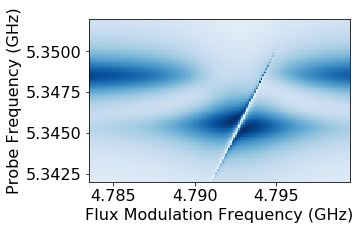

In [4]:
plt.figure(figsize=(5, 3))
plt.imshow(np.abs(result).T,
           extent=[omegad[0]/(4*np.pi)/1e9, omegad[-1]/(4*np.pi)/1e9,
                   omegap[0]/(2*np.pi)/1e9, omegap[-1]/(2*np.pi)/1e9],
           origin='lower', aspect=1, cmap='Blues')
plt.xlabel('Flux Modulation Frequency (GHz)')
plt.ylabel('Probe Frequency (GHz)')
plt.show()

Below is Fig. 4 in the paper.

<img src="./transmission.png" alt="transmission" align="left">

## Qubit state stabilization
### Hamiltonian
The Hamiltonian in lab frame is
$$H = \omega_r a^\dagger a+\frac{\omega_q}{2}\sigma_z+\frac{\Omega_x}{2}\left(\sigma_+e^{-i(\omega_q-\Omega_z)t} + \sigma_-e^{i(\omega_q-\Omega_z)t}\right)-g_b(e^{-i\omega_d t}+e^{i\omega_d t})(a^\dagger + a)(\sigma_+ + \sigma_-).$$
When $\Omega_{z,R}\ll\omega_q$ and $\omega_d\approx\omega_r+\omega_q$, we can set
$$H_0 = (\omega_d-\omega_q+\Omega_z)a^\dagger a + \frac{\omega_q-\Omega_z}{2}\sigma_z,$$
and the interaction picture Hamiltonian (using rotating wave approximation) is
$$H_\text{int} = (\omega_r+\omega_q-\Omega_z-\omega_d)a^\dagger a + \frac{\Omega_z}{2}\sigma_z+\frac{\Omega_x}{2}\sigma_x-g_b(a^\dagger\sigma_+ + a\sigma_+).$$
### Parameters
When the qubit Rabi drive is detuned from $\omega_q$ by $\Omega_z$, the dressed state that will be stabilized is
$|\tilde{g}\rangle=\cos\frac{\theta}{2}|g\rangle - \sin\frac{\theta}{2}|e\rangle$, where $\theta = \arccos(\Omega_z/\Omega_R) = \arccos(\Omega_z/\sqrt{\Omega_x^2+\Omega_z^2})$.

The flux modulation frequency that provides resonant interaction between $|\tilde g1\rangle$ and $|\tilde e0\rangle$ is $\omega_d=\omega_r+\omega_q-\Omega_z-\Omega_R$.

### Simulation

In [5]:
omegar = 4.343e9*2*np.pi
omegaq = 5.439e9*2*np.pi
Omegax = 9e6*2*np.pi
gb = 0.5e6*2*np.pi

H0 = (omegar + omegaq)*adag*a + Omegax*sx/2 - gb*(adag*sp + a*sm)

# Functions
def calcRho(Omegaz):
    # Calculate steady state rho for given Omeagz
    omegad = omegar + omegaq - Omegaz - np.sqrt(Omegax**2+Omegaz**2)
    H = H0 - (Omegaz+omegad)*adag*a + Omegaz*sz/2
    return qt.steadystate(H, cops)


def evolve(Omegaz, psi0, tlist):
    # Calculate time evolution for given Omegaz and tlist
    omegad = omegar + omegaq - Omegaz - np.sqrt(Omegax**2+Omegaz**2)
    H = H0 - (Omegaz+omegad)*adag*a + Omegaz*sz/2
    result = qt.mesolve(H, psi0, tlist, cops, [sx, sy, sz], progress_bar=True)
    return result.expect

In [6]:
# Sweep Omegaz and calculate steady state
theta = np.linspace(1, 179, 51)/180*np.pi
Omegaz = np.cos(theta)/np.sqrt(1-np.cos(theta)**2)*Omegax
rhoss = qt.parallel_map(calcRho, Omegaz, progress_bar=True)
sxexp = np.zeros(Omegaz.shape)
syexp = np.zeros(Omegaz.shape)
szexp = np.zeros(Omegaz.shape)
thetaexp = np.zeros(Omegaz.shape)
purity = np.zeros(Omegaz.shape)
for ii, rho in enumerate(rhoss):
    [sxexp[ii], syexp[ii], szexp[ii]] = qt.expect([sx, sy, sz], rho)
    thetaexp[ii] = np.arccos(-szexp[ii])
    purity[ii] = np.sqrt(sxexp[ii]**2 + syexp[ii]**2 + szexp[ii]**2)

11.8%. Run time:   0.09s. Est. time left: 00:00:00:00
21.6%. Run time:   0.12s. Est. time left: 00:00:00:00
31.4%. Run time:   0.14s. Est. time left: 00:00:00:00
41.2%. Run time:   0.16s. Est. time left: 00:00:00:00
51.0%. Run time:   0.19s. Est. time left: 00:00:00:00
60.8%. Run time:   0.20s. Est. time left: 00:00:00:00
70.6%. Run time:   0.24s. Est. time left: 00:00:00:00
80.4%. Run time:   0.26s. Est. time left: 00:00:00:00
90.2%. Run time:   0.28s. Est. time left: 00:00:00:00
100.0%. Run time:   0.30s. Est. time left: 00:00:00:00
Total run time:   0.33s


In [7]:
# Time evolution for theta = 135 deg
theta0 = 135/180*np.pi
Omegaz = np.cos(theta0)/np.sqrt(1-np.cos(theta0)**2)*Omegax
psi0 = qt.tensor(qt.basis(Nmax, 0), qt.basis(2, 1))
tlist = np.linspace(0, 3e-6, 301)

result = evolve(Omegaz, psi0, tlist)
xtraj = result[0]
ytraj = result[1]
ztraj = result[2]

10.3%. Run time:   0.01s. Est. time left: 00:00:00:00
20.3%. Run time:   0.02s. Est. time left: 00:00:00:00
30.2%. Run time:   0.03s. Est. time left: 00:00:00:00
40.2%. Run time:   0.03s. Est. time left: 00:00:00:00
50.2%. Run time:   0.04s. Est. time left: 00:00:00:00
60.1%. Run time:   0.05s. Est. time left: 00:00:00:00
70.1%. Run time:   0.06s. Est. time left: 00:00:00:00
80.1%. Run time:   0.07s. Est. time left: 00:00:00:00
90.0%. Run time:   0.08s. Est. time left: 00:00:00:00
Total run time:   0.08s


### Result

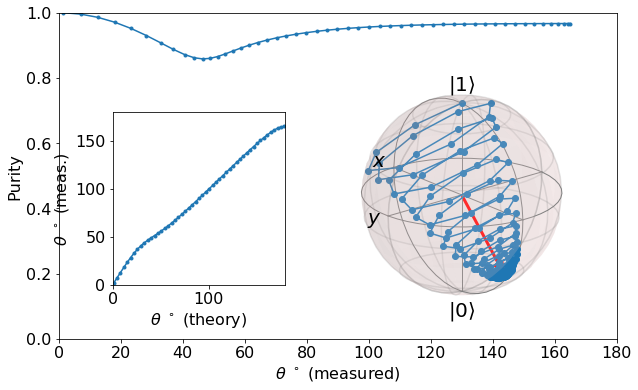

In [8]:
fig = plt.figure(figsize=(10, 6))
plt.plot(thetaexp/np.pi*180, purity, '.-')
plt.xlim([0, 180])
plt.ylim([0, 1])
plt.xlabel(r'$\theta\ ^\circ$ (measured)')
plt.ylabel('Purity')

ax = plt.axes([.2, .25, .24, .4])
plt.plot(theta/np.pi*180, thetaexp/np.pi*180, '.-')
plt.xlim([0, 180])
plt.ylim([0, 180])
plt.xlabel(r'$\theta\ ^\circ$ (theory)')
plt.ylabel(r'$\theta\ ^\circ$ (meas.)')

ax = Axes3D(fig, [.5, .15, .36, .6], azim=50, elev=160)
bsphere = qt.Bloch(fig=fig, axes=ax)
bsphere.make_sphere()
bsphere.axes.plot(ytraj, -xtraj, ztraj, '.-', markersize=12)
bsphere.add_vectors([xtraj[-1], ytraj[-1], ztraj[-1]])
bsphere.vector_color = ['r']
bsphere.plot_vectors()

plt.show()

Below is Fig. 5c in the paper.

<img src="./purity.png" alt="purity" align="left">

In [9]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.3.0.dev0+781856e8
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.26
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
